Now consider the function $f_2(x) = \int_0^\infty e^{-t}(1 + xt)^{-1}\,dt$, which is defined for all real $x > 0$ (in fact, everywhere in the complex $x$-plane except the negative real axis). Replacing $(1 + xt)^{-1}$ by its Maclaurin expansion and integrating term-by-term gives the asymptotic expansion
\begin{equation}
    1 - 1! x + 2!x^2 - 3!x^3 + 4!x^4 - 5!x^5 + \cdots,
\end{equation}
which diverges for all $x \neq 0$, since the Maclaurin expansion of $(1+xt)^{-1}$ diverges for $t \geq x^{-1}$. Nevertheless, when truncated at a finite number of terms, the series gives a good approximation to $f_2(x)$ when $x$ is small.


The first approximation method is to simply truncate the asymptotic series after $N+1$ terms (up to the power $x^N$). This is expected to be a good approximation only when $x$ is small. The second method involves using the coefficients $c_k = (-1)^k k!$ to generate diagonal Padé approximants $R_{L,L}(x)$.

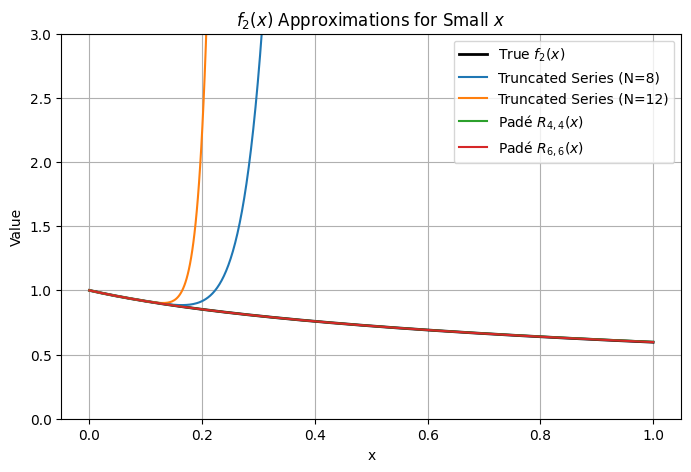

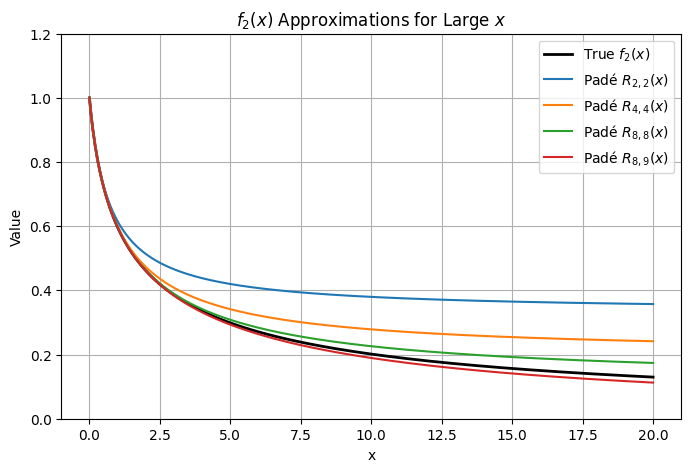

In [3]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import exp1

def pade_approximant(c, L, M, x_values):
    '''
    Calculates the [L, M] Padé approximant for a given power series.
    Args:
        c: The coefficients of the power series must have at least L + M + 1 elements.
        L: The degree of the numerator polynomial.
        M: The degree of the denominator polynomial.
        x_values (list or np.ndarray): The set of x values at which to evaluate
                                       the approximant.

    Returns:
        The evaluated Padé approximant R_L,M(x) for each x in x_values.
        The coefficients p_k of the numerator.
        The coefficients q_k of the denominator (including q_0 = 1).
    '''
    if len(c) < L + M + 1:
        raise ValueError("Not enough coefficients c_k provided for the given L and M.")

    # Solve for the denominator coefficients q_k
    A = np.zeros((M, M))
    b = np.zeros(M)

    for i in range(M):
        b[i] = -c[L + 1 + i]
        for j in range(M):
            idx = L + i - j
            if idx >= 0:
                A[i, j] = c[idx]

    try:
        q_solved = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("The matrix for solving q_k is singular.")
        print("A diagonal Padé approximant may not exist.")
        return np.full_like(x_values, np.nan, dtype=float)

    q_coeffs = np.concatenate(([1.0], q_solved))

    # Calculate the numerator coefficients p_k
    p_coeffs = np.zeros(L + 1)
    for k in range(L + 1):
        sum_term = 0
        for s in range(1, min(k, M) + 1):
            sum_term += q_solved[s-1] * c[k-s]
        p_coeffs[k] = c[k] + sum_term

    # Evaluate the Padé approximant
    x = np.array(x_values, dtype=float)
    P_x = np.polyval(p_coeffs[::-1], x)
    Q_x = np.polyval(q_coeffs[::-1], x)

    with np.errstate(divide='ignore', invalid='ignore'):
        R_x = P_x / Q_x

    return R_x

def truncated_series(c, N, x_values):
    '''
    Evaluates the truncated power series up to N terms.
    '''
    poly_coeffs = c[:N+1][::-1]
    return np.polyval(poly_coeffs, x_values)

def get_f2_coefficients(num_coeffs):
    c = np.zeros(num_coeffs)
    for k in range(num_coeffs):
        c[k] = ((-1)**k) * math.factorial(k)
    return c

def true_f2(x):
    '''
    Calculates the true value of f2(x) using the exponential integral.
    '''
    # Avoid division by zero at x=0, where we know the value is 1.
    x = np.asarray(x)
    results = np.zeros_like(x, dtype=float)

    mask = x > 0
    x_safe = x[mask]
    results[mask] = (1.0 / x_safe) * np.exp(1.0 / x_safe) * exp1(1.0 / x_safe)

    mask_zero = x == 0
    results[mask_zero] = 1.0
    return results

MAX_COEFFS = 30
coeffs = get_f2_coefficients(MAX_COEFFS)

x_small = np.linspace(0, 1, 500)
plt.figure(figsize=(8, 5))
plt.plot(x_small, true_f2(x_small), 'k-', label='True $f_2(x)$', linewidth=2)
plt.plot(x_small, truncated_series(coeffs, 8, x_small), '-', label='Truncated Series (N=8)')
plt.plot(x_small, truncated_series(coeffs, 12, x_small), '-', label='Truncated Series (N=12)')
plt.plot(x_small, pade_approximant(coeffs, 4, 4, x_small), '-', label='Padé $R_{4,4}(x)$')
plt.plot(x_small, pade_approximant(coeffs, 6, 6, x_small), '-', label='Padé $R_{6,6}(x)$')

plt.ylim(0, 3)
plt.title('$f_2(x)$ Approximations for Small $x$')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

x_large = np.linspace(0, 20, 500)

plt.figure(figsize=(8, 5))
plt.plot(x_large, true_f2(x_large), 'k-', label='True $f_2(x)$', linewidth=2)
plt.plot(x_large, pade_approximant(coeffs, 2, 2, x_large), '-', label='Padé $R_{2,2}(x)$')
plt.plot(x_large, pade_approximant(coeffs, 4, 4, x_large), '-', label='Padé $R_{4,4}(x)$')
plt.plot(x_large, pade_approximant(coeffs, 8, 8, x_large), '-', label='Padé $R_{8,8}(x)$')
plt.plot(x_large, pade_approximant(coeffs, 8, 9, x_large), '-', label='Padé $R_{8,9}(x)$')

plt.ylim(0, 1.2)
plt.title('$f_2(x)$ Approximations for Large $x$')
plt.xlabel('x')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


For very small $x$, the truncated power series is a good pproximation. However, as $x$ increases, it diverges to infinity. In fact, taking more terms while making the approximation more accuracy will also cause divergence to happen sooner. The Padé approximants remain close to the true value for much longer and increasing the degree makes the approximation more accurate.

However, the true function $f_2(x)$ slowly decays to zero as $x \to \infty$, whereas a diagonal rational function such as $R_{L,L}(x)$ approaches a non-zero constant $p_L / q_L$ as $x \to \infty$. The Padé approximations flatten out and diverge from the true function for very large $x$. This issue could be fixed by using a different form for the approximant, such as $R_{L,L+1}(x)$, which is designed to decay like $1/x$.